# Blob detection
## LOG
使用高斯二阶导，拉普拉斯算子进行卷积，可以找出斑点圆，但是此方法需要通过调整不同的sigma，来确定不同斑点圆。较大的半径，就需要较大的sigma，但是模板长度6*sigma+1，会带来很大的计算量。
## DOG加速计算
DOG加速是一方面，另一方面，使用空间金字塔，多个金字塔来加速不同尺度的对比。

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# from cv import conv_img

3
0.20151459356636447


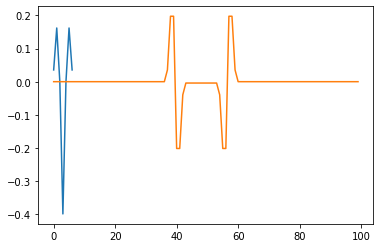

In [ ]:
y = np.zeros(100)
for i in range(1, 2):
    sigma = 1
    y[40:57] = 1
    width = 6*sigma + 1
    laplace = np.zeros(width)
    center = width >> 1
    print(center)
    for i in range(width):
        # 一维norm-laplace算子公式
        laplace[i] = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp((-1 / (2*sigma**2)) * (i-center)**2) * (1 / sigma**4) * ((i-center)**2 - sigma**2)
    plt.plot(laplace)
    z = np.zeros(100)
    for j in range(center, 100-center):
        z[j] = np.sum(y[j-center:j+center+1] * laplace) * sigma ** 2
    plt.plot(z)
    print(np.max(abs(z)))

In [4]:
def gaussian_template(sigma):
    width = int(6*sigma+1)
    if width % 2 == 0:
        width += 1
    gaussian = np.zeros(shape=(width, width))
    center = width >> 1
    # print(center)
    for i in range(width):
        for j in range(width):
            gaussian[i, j] = 1 / (2 * np.pi * sigma**2) * np.exp((-1 / (2*sigma**2)) * ((i-center)**2+(j-center)**2))
    s = np.sum(gaussian)
    # 归一化防止图像低于255
    gaussian = gaussian / s
    return gaussian

def norm_laplacian_template(sigma):
    # 标准化的二阶拉普拉斯算子已经乘sigma**2
    width = int(6*sigma+1)
    if width % 2 == 0:
        width += 1
    laplace = np.zeros(shape=(width, width))
    center = width >> 1
    # print(center)
    for i in range(width):
        for j in range(width):
            laplace[i, j] = 1 / (2 * np.pi * sigma ** 2) * (np.exp((-1 / (2*sigma**2)) * ((i-center)**2+(j-center)**2))) * (1 / sigma**2) * ((i-center)**2 + (j-center)**2 - 2 * sigma**2)
    return laplace

def conv_img(img, conv_template):
    a, b = img.shape
    a_, b_ = conv_template.shape
    a_ = a_ // 2
    b_ = b_ // 2
    img_ = np.zeros(shape=(a+2*a_, b+2*b_))
    img = np.pad(img, ((a_, a_), (b_, b_)), "constant", constant_values=(0, 0))
    for i in range(a_, a+a_):
        for j in range(b_, b+b_):
            cell = img[i-a_:i+a_+1, j-b_:j+b_+1]
            img_[i, j] = np.sum(cell * conv_template)
    return img_[a_:a+a_, b_:b+b_]

def get_dog_pyramid(octaves_num, sigma, s, img):
    images_num = s + 3
    k = np.power(2, 1/s)
    sigmas_list = [sigma] # 对应图像的sigma
    for i in range(1, images_num):
        tem = np.power(k, i) * sigma
        sigmas_list.append(np.sqrt(tem**2 - sigmas_list[i-1]**2))
    gaussian_scaled_pyramid = {}
    dog_pyramid = {}
    # 对每一组octave进行高斯处理
    for i in range(octaves_num):
        gaussian_scaled_pyramid[i] = []
        if i == 0:
            # 第一张图像不用动
            tem_img = img.copy()
        else:
            # 从第二组开始的图像都是前一组图像降采样得来的结果
            tem_img = tem_img[::2, ::2]
        cur_img = tem_img.copy()
        for j in range(images_num):
            cur_img = conv_img(cur_img, gaussian_template(sigmas_list[j]))
            gaussian_scaled_pyramid[i].append(cur_img.copy())
    # 构建差分金字塔
    for i in range(octaves_num):
        dog_pyramid[i] = []
        for j in range(1, images_num):
            dog_pyramid[i].append(gaussian_scaled_pyramid[i][j] - gaussian_scaled_pyramid[i][j-1])
    return dog_pyramid

def get_main_direction(cor, bin_num, sigma, img):
    x, y = cor
    dx_list = []
    dy_list = []
    ori_list = []
    tem_hist = [0] * bin_num
    radius = int(4.5*sigma)
    k = 0
    for i in range(-radius, radius+1):
        tem_x = x + i
        if tem_x <= 0 or tem_x >= img.shape[0] - 1:
            continue
        for j in range(-radius, radius+1):
            tem_y = y + j
            if tem_y <= 0 or tem_y >= img.shape[1] - 1:
                continue
            dx = img[tem_x, tem_y+1] - img[tem_x, tem_y-1]
            dy = img[tem_x+1, tem_y] - img[tem_x-1, tem_y]
            ori_list.append(np.arctan2(dy, dx)*180/np.pi)
            dx_list.append(dx)
            dy_list.append(dy)
            k += 1
    dx_list = np.array(dx_list)
    dy_list = np.array(dy_list)
    ori_list = np.array(ori_list)
    mag = (dx_list**2 + dy_list**2) ** 0.5
    for v in range(k):
        bin = int((bin_num / 360) * ori_list[v])
        if bin >= bin_num:
            bin -= bin_num
        if bin < 0:
            bin += bin_num
        tem_hist[bin] += mag[v]
    return np.argmax(tem_hist) * 10

# 计算SIFT描述子：1. 计算旋转差 2. 计算需要运算的区域 3. 计算每个区域的SIFT特征 4. 加权暂且不做
def calc_sift_desc(cor, sigma, direction, img):
    x, y = cor
    bin_n = 8
    tem_a, tem_b = img.shape
    # 如果需要线性插值及准确划定格子范围则需要
    # cos_t = np.cos(direction * (np.pi / 180))
    # sin_t = np.sin(direction * (np.pi / 180))
    hist_width = 16
    radius = 8
    dx_list = []
    dy_list = []
    dw_list = []
    dst = [] # 储存4*4*8的SIFT描述子
    # 计算格子里面的每一个Ix和Iy
    k = 0
    for i in range(-radius, radius):
        for j in range(-radius, radius):
            r = x + i
            c = y + j
            if 1 <= r < tem_a-1 and 1 <= c < tem_b-1:
                dx = img[r, c+1] - img[r, c-1]
                dy = img[r-1, c] - img[r+1, c]
                dx_list.append(dx)
                dy_list.append(dy)
            else:
                dx_list.append(0)
                dy_list.append(0)
            k += 1
    length = k # 不能确定一定是16个
    dx_list = np.array(dx_list)
    dy_list = np.array(dy_list)
    ori_list = np.arctan2(dy_list, dx_list) * 180 / np.pi
    mag_list = (dx_list**2 + dy_list**2) ** 0.5
    tem_dx_list = dx_list.reshape((16, 16))
    tem_dy_list = dy_list.reshape((16, 16))
    tem_mag_list = mag_list.reshape((16, 16))
    tem_ori_list = np.zeros(shape=(1, length))
    for k in range(length):
        ori = int((ori_list[k] - direction) * 8 / 360)
        if ori < 0:
            ori += bin_n
        if ori >= bin_n:
            ori -= bin_n
        tem_ori_list[0, k] = ori
    tem_ori_list = tem_ori_list.reshape((16, 16))
    for i in range(4):
        for j in range(4):
            tem_ori = tem_ori_list[i*4: (i+1)*4, j*4: (j+1)*4].reshape((1, 16))
            tem_mag = tem_mag_list[i*4: (i+1)*4, j*4: (j+1)*4].reshape((1, 16))
            tem_mag_bin = [0]*bin_n
            for v in range(16):
                tem_mag_bin[int(tem_ori[0, v])] += tem_mag[0, v]
            for l in tem_mag_bin:
                dst.append(l)
    return dst

# 改进SIFT特征描述符（+3*sigma半径+线性插值）
def calc_sift_descriptor(cor, sigma, direction, img):
    # 1. 计算半径r
    x, y = cor
    d = 4 # 四个区域
    bin_n = 8 # 分成八个方向，得到4*4*8
    radius = int(3 * sigma * np.sqrt(2) * (d+1) // 2)
    img_a, img_b = img.shape
    dx_list = [] # 储存x方向梯度
    dy_list = [] # 储存y方向梯度
    x_bin = [] # 储存x方向梯度值
    y_bin = [] # 储存y方向梯度值
    mag_list = [] # 储存梯度值
    ori_list = [] # 储存梯度方向
    hist = [0]*(d+2)*(d+2)*(bin_n+2) # 储存线性插值之后的值
    dst = [] # 储存最终描述子

    # 2. 计算主方向移动至正方向的旋转矩阵
    cos_t = np.cos(direction * (np.pi / 180)) / (3 * sigma) # 为了从radius变回bin里面的值
    sin_t = np.sin(direction * (np.pi / 180)) / (3 * sigma)

    # 3. 计算
    k = 0
    for i in range(-radius, radius+1):
        tem_x = x + i
        for j in range(-radius, radius+1):
            tem_y = y + j
            x_prime = i*cos_t - j*sin_t
            y_prime = i*sin_t + j*cos_t
            tem_x_bin = x_prime + d//2 - 0.5
            tem_y_bin = y_prime + d//2 - 0.5
            if -1 < tem_x_bin < d and -1 < tem_y_bin < d and 0 < tem_x < img_a-1 and 0 < tem_y < img_b-1:
                dx = img[tem_x, tem_y+1] - img[tem_x, tem_y-1]
                dy = img[tem_x+1, tem_y] - img[tem_x-1, tem_y]
                dx_list.append(dx)
                dy_list.append(dy)
                x_bin.append(tem_x_bin)
                y_bin.append(tem_y_bin)
                k += 1

    # 4. 计算梯度及方向角
    length = k
    dx_list = np.array(dx_list)
    dy_list = np.array(dy_list)
    ori_list = np.arctan2(dy_list, dx_list) * 180 / np.pi
    mag_list = (dx_list ** 2 + dy_list ** 2) ** 0.5

    # 5. 三线性插值
    for k in range(length):
        tem_x_bin = x_bin[k]
        tem_y_bin = y_bin[k]
        tem_ori_bin = (ori_list[k]-direction) * bin_n / 360
        tem_mag = mag_list[k]
        x_0 = int(tem_x_bin)
        y_0 = int(tem_y_bin)
        o_0 = int(tem_ori_bin)
        tem_x_bin -= x_0
        tem_y_bin -= y_0
        tem_ori_bin -= o_0
        if o_0 < 0:
            o_0 += bin_n
        if o_0 >= bin_n:
            o_0 -= bin_n

        # 三线性插值
        v_r1 = tem_mag * tem_x_bin
        v_r0 = tem_mag - v_r1

        v_rc11 = v_r1 * tem_y_bin
        v_rc10 = v_r1 - v_rc11
        v_rc01 = v_r0 * tem_y_bin
        v_rc00 = v_r0 - v_rc01

        v_rco111 = v_rc11 * tem_ori_bin
        v_rco110 = v_rc11 - v_rco111
        v_rco101 = v_rc10 * tem_ori_bin
        v_rco100 = v_rc10 - v_rco101
        v_rco011 = v_rc01 * tem_ori_bin
        v_rco010 = v_rc01 - v_rco101
        v_rco001 = v_rc00 * tem_ori_bin
        v_rco000 = v_rc00 - v_rco001

        idx = ((x_0 + 1) * (d + 2) + y_0 + 1) * (bin_n + 2) + o_0
        
        hist[idx] += v_rco000
        hist[idx+1] += v_rco001
        hist[idx+(bin_n+2)] += v_rco010
        hist[idx+(bin_n+3)] += v_rco011
        hist[idx+(d+2)*(bin_n+2)] += v_rco100
        hist[idx+(d+2)*(bin_n+2)+1] += v_rco101
        hist[idx+(d+3)*(bin_n+2)] += v_rco110
        hist[idx+(d+3)*(bin_n+2)+1] += v_rco111

    # 最后完成d*d*n的统计
    for i in range(d):
        for j in range(d):
            idx = ((i+1)*(d+2) + (j+1)) * (bin_n+2)
            # 为了防止角度超过，漏算插值
            hist[idx] += hist[idx+bin_n]
            hist[idx+1] += hist[idx+bin_n+1]
            for k in range(bin_n):
                dst.append(hist[idx+k])

    # 归一化，不是一定要做
    nrm_2 = 0
    length = d*d*bin_n
    for k in range(length):
        nrm_2 += dst[k] * dst[k]
    thr = np.sqrt(nrm_2) * 0.2

    nrm_2 = 0
    for k in range(length):
        val = min(dst[k], thr)
        dst[k] = val
        nrm_2 += val * val
    
    nrm_2 = 512 / np.sqrt(nrm_2)
    for k in range(length):
        dst[k] = min(max(dst[k]*nrm_2, 0), 255)
    return dst

def get_key_points(octaves_num, dog_pyramid, images_num, sigma=1.6):
    dog_threshold = 0.06
    threshold = 0.5 * dog_threshold / 3 * 255
    key_points = {}
    gamma = 5
    for i in range(octaves_num):
        for j in range(1, images_num-2):
            down_img = dog_pyramid[i][j-1]
            mid_img = dog_pyramid[i][j]
            up_img = dog_pyramid[i][j+1]
            # 是否是局部极值，简单起见只考虑极大值
            row, col = mid_img.shape
            for k in range(1, row-1):
                for v in range(1, col-1):
                    if mid_img[k, v] >= threshold and mid_img[k, v] == max(np.max(mid_img[k-1:k+2, v-1:v+2]), np.max(up_img[k-1:k+2, v-1:v+2]), np.max(down_img[k-1:k+2, v-1:v+2])):
                        # 子像素插值
                        max_iters = 5
                        convergence = False
                        k_, v_, j_ = k, v, j
                        for _ in range(max_iters):
                            if convergence:
                                break
                            d_x = np.mat([(mid_img[k_][v_+1] - mid_img[k_][v_-1])*0.5, 0.5*(mid_img[k_+1][v_] - mid_img[k_-1][v_]), 0.5*(up_img[k_, v_]-down_img[k_, v_])]).T
                            d_xx = mid_img[k_][v_+1] + mid_img[k_][v_-1] - 2*mid_img[k_][v_]
                            d_yy = mid_img[k_+1][v_] + mid_img[k_-1][v_] - 2*mid_img[k_][v_]
                            d_sigma_2 = up_img[k_][v_] + down_img[k_][v_] - 2*mid_img[k_][v_]
                            d_xy = (mid_img[k_+1][v_+1] + mid_img[k_-1][v_-1] - mid_img[k_+1][v_-1] - mid_img[k_-1][v_+1]) * 0.25
                            d_x_sigma = (up_img[k_][v_+1] + down_img[k_][v_-1] - up_img[k_][v_-1] - down_img[k_][v_+1]) * 0.25
                            d_y_sigma = (up_img[k_-1][v_] + down_img[k_+1][v_] - up_img[k_+1][v_] - down_img[k_-1][v_]) * 0.25
                            dd_x = np.mat([[d_xx, d_xy, d_x_sigma], [d_xy, d_yy, d_y_sigma], [d_x_sigma, d_y_sigma, d_sigma_2]])
                            offset = - dd_x.I * d_x
                            if np.abs(offset[0]) < 0.5 and np.abs(offset[1]) < 0.5 and np.abs(offset[2]) < 0.5:
                                response = mid_img[k_][v_] + 0.5 * d_x.T * offset
                                if response > threshold:
                                    convergence = True
                            else:
                                k_ += int(offset[0])
                                v_ += int(offset[1])
                                j_ += int(offset[2])
                                if j_ < 1 or j_ > images_num - 2 or k_ < 1 or k_ >= row-1 or v_ < 1 or v_ >= col-1:
                                    break
                        if convergence:
                            trace = d_xx + d_yy
                            det = d_xx * d_yy - d_xy*d_xy
                            if det > 0 and (trace * trace) / det < (gamma+1)**2 / gamma:
                                # 如果不用结构体，则使用元组记录所有信息
                                k_ = k * np.power(2, i)
                                v_ = v * np.power(2, i)
                                size = sigma * np.power(2, i) * np.power(2, j/s)
                                response = mid_img[k, v]
                                # 计算主方向
                                direction = get_main_direction((k, v), 36, size, mid_img)
                                dst = calc_sift_descriptor((k, v), size, direction, mid_img)
                                if not key_points.get((k_, v_)):
                                    key_points[(k_, v_)] = (size, response, direction, dst)
                                else:
                                    _, res, _, _ = key_points[(k_, v_)]
                                    if res < response:
                                        key_points[(k_, v_)] = (size, response, direction, dst)
    return key_points

(312, 485, 4)


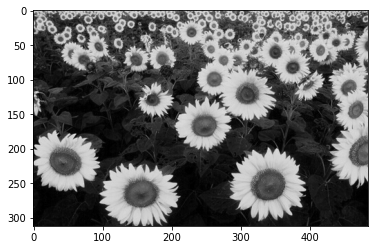

In [25]:
img = plt.imread('./flower.jpg')
img = np.array(img)
print(img.shape)
a, b, c = img.shape
new_img = np.zeros(shape=(a, b))
for i in range(a):
    for j in range(b):
        new_img[i, j] = img[i, j].mean()
min_val = np.min(new_img)
max_val = np.max(new_img)
new_img = ((new_img - min_val) / (max_val - min_val)) * 255
plt.imshow(new_img, cmap="gray")
s = 3
sigma = 1.6
min_size = 4 # 表示最小的框为16*16
min_length = min(a, b)
octaves_num = int(np.log(min_length)/ np.log(2)) - min_size
new_dog_pyr = get_dog_pyramid(octaves_num, sigma, s, new_img)
new_key_point_dic = get_key_points(octaves_num, new_dog_pyr, s+3)

In [26]:
print(len(new_key_point_dic))

838


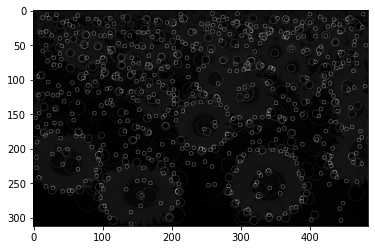

In [27]:
blob_img_ = new_img.copy()
for cor in new_key_point_dic:
    x, y = cor
    size, _, _, _ = new_key_point_dic[cor]
    r = size * np.sqrt(2)
    for theta in np.arange(0, 2*np.pi, 0.1):
        blob_img_[int(x+r*np.cos(theta)), int(y+r*np.sin(theta))] += 255
plt.imshow(blob_img_, cmap="gray")

(1163, 800, 3)


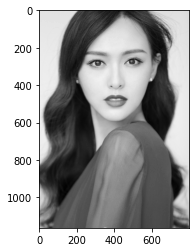

In [6]:
# 测试数据
img = plt.imread('./tangyan-1.jpg')
img = np.array(img)
print(img.shape)
a, b, c = img.shape
new_img = np.zeros(shape=(a, b))
for i in range(a):
    for j in range(b):
        new_img[i, j] = img[i, j].mean()
min_val = np.min(new_img)
max_val = np.max(new_img)
new_img = ((new_img - min_val) / (max_val - min_val)) * 255
plt.imshow(new_img, cmap="gray")
s = 3
sigma = 1.6
min_size = 4 # 表示最小的框为16*16
min_length = min(a, b)
octaves_num = int(np.log(min_length)/ np.log(2)) - min_size
new_dog_pyr = get_dog_pyramid(octaves_num, sigma, s, new_img)
new_key_point_dic = get_key_points(octaves_num, new_dog_pyr, s+3)

(1152, 800, 3)


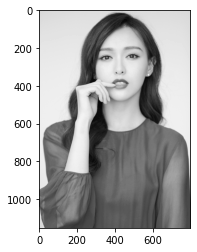

In [7]:
# 测试数据
img = plt.imread('./tangyan-2.jpg')
img = np.array(img)
print(img.shape)
a, b, c = img.shape
new_img_1 = np.zeros(shape=(a, b))
for i in range(a):
    for j in range(b):
        new_img_1[i, j] = img[i, j].mean()
min_val = np.min(new_img_1)
max_val = np.max(new_img_1)
new_img_1 = ((new_img_1 - min_val) / (max_val - min_val)) * 255
plt.imshow(new_img_1, cmap="gray")
s = 3
sigma = 1.6
min_size = 4 # 表示最小的框为16*16
min_length = min(a, b)
octaves_num = int(np.log(min_length)/ np.log(2)) - min_size
new_1_dog_pyr = get_dog_pyramid(octaves_num, sigma, s, new_img_1)
new_1_key_point_dic = get_key_points(octaves_num, new_1_dog_pyr, s+3)

In [8]:
print(len(new_key_point_dic), len(new_1_key_point_dic))

460 423


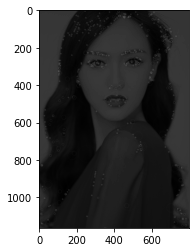

In [11]:
blob_img_ = new_img.copy()
for cor in new_key_point_dic:
    x, y = cor
    size, _, _, _ = new_key_point_dic[cor]
    r = size * np.sqrt(2)
    for theta in np.arange(0, 2*np.pi, 0.1):
        blob_img_[int(x+r*np.cos(theta)), int(y+r*np.sin(theta))] += 100
plt.imshow(blob_img_, cmap="gray")
plt.imsave('./test-1.jpg', blob_img_)

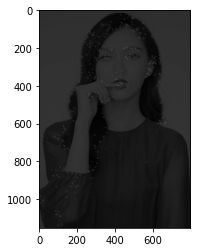

In [12]:
blob_img_ = new_img_1.copy()
for cor in new_1_key_point_dic:
    x, y = cor
    size, _, _, _ = new_1_key_point_dic[cor]
    r = size * np.sqrt(2)
    for theta in np.arange(0, 2*np.pi, 0.1):
        blob_img_[min(a-1, int(x+r*np.cos(theta))), min(b-1, int(y+r*np.sin(theta)))] += 100
plt.imshow(blob_img_, cmap="gray")
plt.imsave('./test.jpg', blob_img_)

In [9]:
k = 0
distance = []
cor_list = []
for cor in new_key_point_dic:
    x, y = cor
    _, _, _, sift = new_key_point_dic[cor]
    sift = np.array(sift)
    min_val = 1000000
    tem_cor = None
    for cor_ in new_1_key_point_dic:
        x_, y_ = cor_
        _, _, _, sift_ = new_1_key_point_dic[cor_]
        sift_ = np.array(sift_)
        # if np.sum(np.power(sift - sift_, 2)) < 100000:
        #     cor_list.append(((x, y), (x_, y_)))
        if np.sum(np.power(sift - sift_, 2)) <= min_val:
            min_val = np.sum(np.power(sift - sift_, 2))
            tem_cor = cor_
    if tem_cor:
        cor_list.append(((x, y), tem_cor, min_val))

In [10]:
print(len(cor_list))

460


In [13]:
sort_cor_list = sorted(cor_list, key=lambda x: x[-1])

In [16]:
new_cor_list = sort_cor_list[:20]

In [86]:
blob_img_1 = new_img.copy()
blob_img_2 = new_img_1.copy()
for cor_1, cor_2, _ in new_cor_list:
    x, y = cor_1
    x_, y_ = cor_2
    r = 10
    for theta in np.arange(0, 2*np.pi, 0.1):
        blob_img_1[min(a-1, int(x+r*np.cos(theta))), min(b-1, int(y+r*np.sin(theta)))] += 100
        blob_img_2[min(a-1, int(x_+r*np.cos(theta))), min(b-1, int(y_+r*np.sin(theta)))] += 100
plt.imsave("./test.jpg", blob_img_1)
plt.imsave("./test-1.jpg", blob_img_2)

In [31]:
# 实际做法
s = 3
sigma = 1.6
min_size = 4 # 表示最小的框为16*16
min_length = min(a, b)
octaves_num = int(np.log(min_length)/ np.log(2)) - min_size
new_dog_pyr = get_dog_pyramid(octaves_num, sigma, s)
new_key_point_dic = get_key_points(octaves_num, new_dog_pyr, s+3)

TypeError: get_dog_pyramid() missing 1 required positional argument: 'new_img'

In [6]:
# 实际做法
s = 3
sigma = 1.6
min_size = 4 # 表示最小的框为16*16
min_length = min(a, b)
octaves_num = int(np.log(min_length)/ np.log(2)) - min_size
new_1_dog_pyr = get_dog_pyramid(octaves_num, sigma, s)
new_1_key_point_dic = get_key_points(octaves_num, new_dog_pyr, s+3)

5
4
7
7
10
12
5
4
7
7
10
12
5
4
7
7
10
12
5
4
7
7
10
12


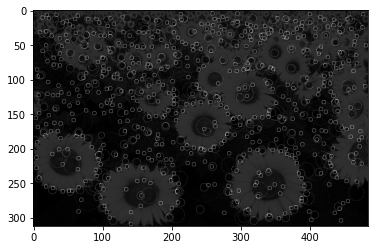

In [7]:
blob_img_ = new_img.copy()
for cor in new_key_point_dic:
    x, y = cor
    size, _, _, _ = new_key_point_dic[cor]
    r = size * np.sqrt(2)
    for theta in np.arange(0, 2*np.pi, 0.1):
        blob_img_[int(x+r*np.cos(theta)), int(y+r*np.sin(theta))] += 100
plt.imshow(blob_img_, cmap="gray")

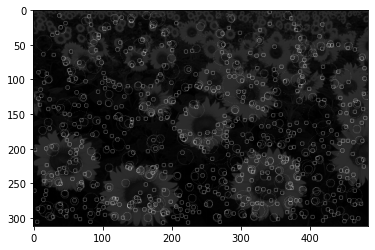

In [15]:
blob_img_ = new_img_1.copy()
for cor in new_1_key_point_dic:
    x, y = cor
    size, _, _, _ = new_1_key_point_dic[cor]
    r = size * np.sqrt(2)
    for theta in np.arange(0, 2*np.pi, 0.1):
        blob_img_[min(a-1, int(x+r*np.cos(theta))), min(b-1, int(y+r*np.sin(theta)))] += 100
plt.imshow(blob_img_, cmap="gray")

In [7]:
# LOG方法
l_tem = norm_laplacian_template(22.6)
l_img = conv_img(new_img, l_tem)
print(new_img.shape)
print(l_img.shape)

68
(312, 485)
(312, 485)


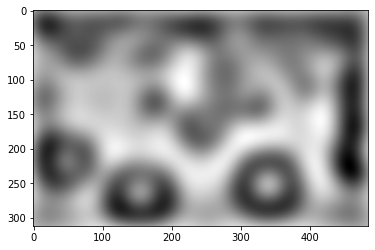

In [8]:
plt.imshow(l_img, cmap="gray")

In [9]:
threshold = np.max(l_img)
nms_img = l_img.copy()
for i in range(1, a):
    for j in range(1, b):
        if l_img[i, j] >= threshold*0.5 and l_img[i, j] == np.max(l_img[i-1:i+2, j-1:j+2]):
            for theta in np.arange(0, 2*np.pi, 0.1):
                r = np.sqrt(2) * 22.6
                nms_img[int(i+r*np.cos(theta)), int(j+r*np.sin(theta))] += threshold

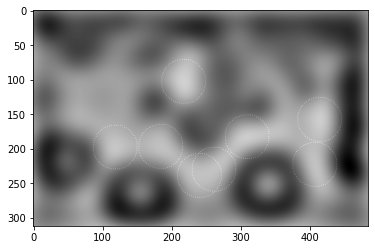

In [10]:
plt.imshow(nms_img, cmap="gray")

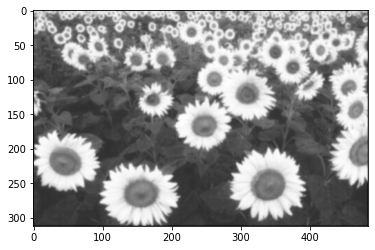

In [11]:
plt.imshow(new_img, cmap="gray")

In [12]:
s = 1
k = np.power(2, 1/s)
sigma = 5
g_dic = {}
g_img = new_img.copy()
# 获取G图像
for i in range(s+3):
    _sigma = sigma * np.power(k, i)
    g_img = conv_img(g_img, gaussian_template(_sigma))
    g_dic[_sigma] = g_img

15
30
60
120


In [13]:
# 提高高斯效率
s = 3
k = np.power(2, 1/s)
sigma = 1
g_dic = {}
l_dic = {}
g_img = new_img.copy()
# 获取G图像和l图像
for i in range(s+3):
    pre_img = g_dic.get(sigma)
    if i > 0:
        sigma = sigma * k
        _sigma = np.sqrt(sigma**2-(sigma / k)**2)
    g_img = conv_img(g_img, gaussian_template(_sigma))
    g_dic[sigma] = g_img
    if pre_img is not None:
        l_dic[sigma / k] = g_img - pre_img

120
2
3
4
5
6


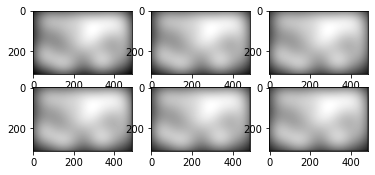

In [14]:
plt.figure()
j = 1
for i in g_dic:
    plt.subplot(3, 3, j)
    plt.imshow(g_dic[i], cmap="gray")
    j += 1

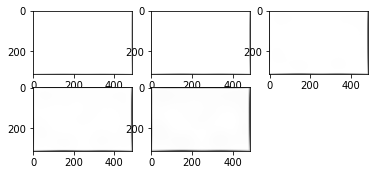

In [15]:
plt.figure()
j = 1
for i in l_dic:
    plt.subplot(3, 3, j)
    plt.imshow(l_dic[i], cmap="gray")
    j += 1

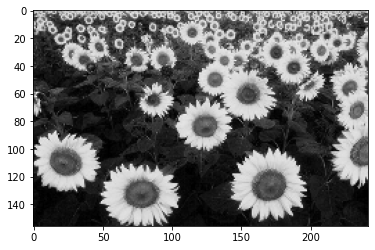

In [5]:
small_img = np.zeros(shape=(a//2, b//2))
for i in range(0, a-1, 2):
    for j in range(0, b-1, 2):
        small_img[i//2, j//2] = new_img[i, j]
plt.imshow(small_img, cmap="gray")

In [17]:
# 提高高斯效率
s = 3
k = np.power(2, 1/s)
sigma = 1
g_dic = {}
l_dic = {}
g_img = small_img.copy()
# 获取G图像和l图像
for i in range(s+3):
    pre_img = g_dic.get(sigma)
    if i > 0:
        sigma = sigma * k
        _sigma = np.sqrt(sigma**2-(sigma / k)**2)
    g_img = conv_img(g_img, gaussian_template(_sigma))
    g_dic[sigma] = g_img
    if pre_img is not None:
        l_dic[sigma / k] = g_img - pre_img

6
2
3
4
5
6


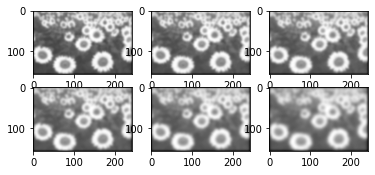

In [18]:
plt.figure()
j = 1
for i in g_dic:
    plt.subplot(3, 3, j)
    plt.imshow(g_dic[i], cmap="gray")
    j += 1

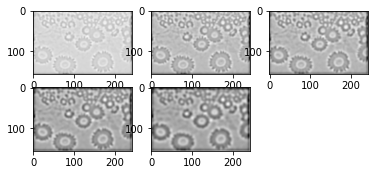

In [19]:
plt.figure()
j = 1
for i in l_dic:
    plt.subplot(3, 3, j)
    plt.imshow(l_dic[i], cmap="gray")
    j += 1

In [33]:
print(new_img.shape, small_img.shape)

(312, 485) (156, 242)


In [28]:
# 提高高斯效率
s = 7
k = np.power(2, 1/s)
sigma = 1.6
ori_g_dic = {}
ori_l_dic = {}
small_g_dic = {}
small_l_dic = {}
ori_g_img = new_img.copy()
small_g_img = small_img.copy()
total_g_dic = {}
total_l_dic = {}
# 获取G图像和l图像
for i in range(s+3):
    pre_ori_img = ori_g_dic.get(sigma)
    pre_small_img = small_g_dic.get(2*sigma)
    _sigma = sigma
    if i > 0:
        sigma = sigma * k
        _sigma = np.sqrt(sigma**2-(sigma / k)**2)
    ori_g_img = conv_img(ori_g_img, gaussian_template(_sigma))
    small_g_img = conv_img(small_g_img, gaussian_template(_sigma))
    # print(small_g_img.shape)
    tem = np.zeros(shape=(a, b))
    for i in range(small_g_img.shape[0]):
        for j in range(small_g_img.shape[1]):
            tem[i*2, j*2] = small_g_img[i, j]
    # small_g_img = tem
    ori_g_dic[sigma] = ori_g_img
    small_g_dic[2*sigma] = tem
    total_g_dic[sigma] = ori_g_img
    total_g_dic[2*sigma] = tem
    if pre_ori_img is not None and pre_small_img is not None:
        ori_l_dic[sigma / k] = ori_g_img - pre_ori_img
        small_l_dic[2 * sigma / k] = tem - pre_small_img
        total_l_dic[sigma / k] = ori_g_img - pre_ori_img
        total_l_dic[2 * sigma / k] = tem - pre_small_img

5
5
2
2
2
2
3
3
3
3
3
3
4
4
4
4
4
4
5
5


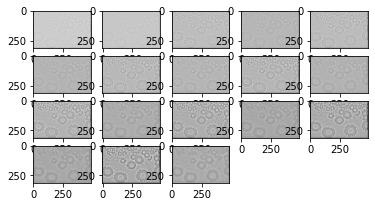

In [29]:
plt.figure()
j = 1
for i in total_l_dic:
    plt.subplot(5, 5, j)
    plt.imshow(total_l_dic[i], cmap="gray")
    j += 1

In [33]:
from queue import PriorityQueue
que = PriorityQueue()
for i in total_l_dic:
    que.put((i, total_l_dic[i]))

In [34]:
blob_img = new_img.copy()
prev_img = que.get()[1]
sigma, mid_img = que.get()
while not que.empty():
    sigma_, end_img = que.get()
    # 非极大值抑制
    threshold = np.max(mid_img) * 0.5
    print(sigma)
    for i in range(1, a-1):
        for j in range(1, b-1):
            if mid_img[i, j] >= threshold and mid_img[i, j] >= max(np.max(mid_img[i-1:i+2, j-1: j+2]), np.max(prev_img[i-1:i+2, j-1: j+2]), np.max(end_img[i-1:i+2, j-1: j+2])):
                for theta in np.arange(0, 2*np.pi, 0.1):
                    r = np.sqrt(2) * sigma
                    blob_img[int(i+r*np.cos(theta)), int(j+r*np.sin(theta))] += 0.5
    prev_img = mid_img
    mid_img = end_img
    sigma = sigma_

1.7665432218780996
1.9504218467271603
2.1534403082117692
2.3775908626191167
2.6250731392244404
2.8983157256445002
3.1999999999999984
3.2
3.5330864437561975
3.5330864437561993
3.9008436934543207
4.3068806164235385
4.755181725238233
5.250146278448881
5.7966314512890005
6.399999999999997


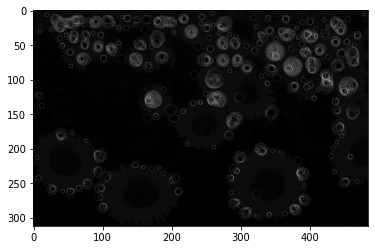

In [35]:
plt.imshow(blob_img, cmap="gray")

8
0.025583230450220096
0.029049428330490734
0.03392196920743612
0.03805751052601697
0.04175449928844832
0.043129767894464655
0.041135577929950706
0.04784402033517782


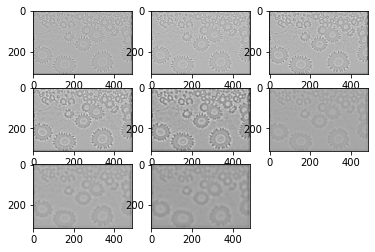

In [40]:
plt.figure()
j = 1
print(que.qsize())
while not que.empty():
    res = que.get()
    plt.subplot(3, 3, j)
    print(np.max(res[1]))
    plt.imshow(res[1], cmap="gray")
    j += 1

877
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1786671425170243, -0.005529495347730406, 0, 9.345152280089344, -2.3499171731925697, 0, 0, 0, 1.710632891446143, -0.028726448891786903, 0, 22.979405958570677, -0.2396932951380462, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.612396766142455, -4.829145365345251, 0, 186.5429526091187, -53.09208954291799, 0, 0, 0, 46.32545581498725, -25.088039469196666, 0, 30.547451418767942, -6.076841702484794, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.851205178221333, 18.29815738869821, -8.839499356934214, 0, 167.23017835831934, -24.438631276472584, 0, 0.7171310312028938, 28.006670987232074, 85.18092714160515, -45.92235105327983, 0, 26.42565478648274, -2.5573028569549563, 0, 1.4511507318923522, 0.6633237493572517, -5.274691732570642e-05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


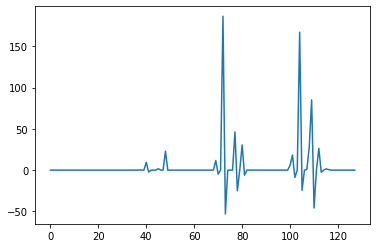

In [17]:
print(len(key_points))
for cor in key_points:
    _, _, _, dst = key_points[cor]
    print(dst)
    plt.plot(dst)
    break

In [25]:
threshold

2

In [56]:
print(len(key_points))

442


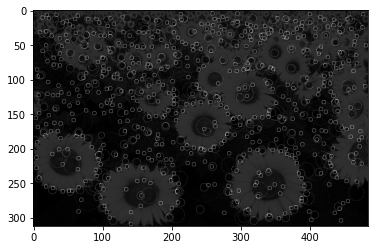

In [18]:
blob_img_ = new_img.copy()
for cor in key_points:
    x, y = cor
    size, _, _, _ = key_points[cor]
    r = size * np.sqrt(2)
    for theta in np.arange(0, 2*np.pi, 0.1):
        blob_img_[int(x+r*np.cos(theta)), int(y+r*np.sin(theta))] += 100
plt.imshow(blob_img_, cmap="gray")
# plt.imsave("./blob_img-1.jpg", blob_img_)

In [52]:
# 特征点匹配
key_points_ = key_points # 代表翻转之后的图像

In [82]:
k = 0
distance = []
cor_list = []
for cor in key_points:
    x, y = cor
    _, _, _, sift = key_points[cor]
    sift = np.array(sift)
    for cor_ in key_points_:
        x_, y_ = cor_
        _, _, _, sift_ = key_points_[cor_]
        sift_ = np.array(sift_)
        if np.sum(np.power(sift - sift_, 2)) < 0.5:
            cor_list.append(((x, y), (x_, y_)))

In [83]:
print(len(cor_list))

408


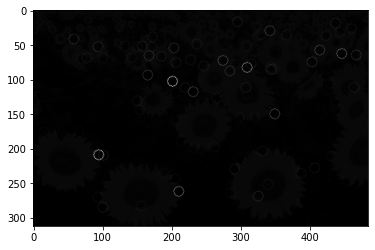

In [99]:
blob_img_ = new_img.copy()
blob_img = new_img_1.copy()
for cor, cor_ in cor_list:
    x, y = cor
    x_, y_ = cor_
    r = 5 * np.sqrt(2)
    for theta in np.arange(0, 2*np.pi, 0.1):
        blob_img_[int(x+r*np.cos(theta)), int(y+r*np.sin(theta))] += 0.2
        blob_img[int(x_+r*np.cos(theta)), int(y_+r*np.sin(theta))] += 0.2
plt.imshow(blob_img_, cmap="gray")

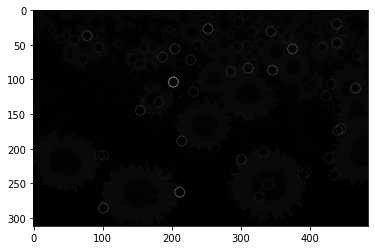

In [102]:
plt.imshow(blob_img[::-1, ::-1], cmap="gray")

In [76]:
print(len(np.where(np.array(distance) < 0.5)[0]))

408


In [34]:
blob_img = new_img.copy()
for cor in key_points:
    x, y = cor
    size, _ = key_points[cor]
    r = size * np.sqrt(2)
    for theta in np.arange(0, 2*np.pi, 0.1):
        blob_img[int(x+r*np.cos(theta)), int(y+r*np.sin(theta))] += 0.5
    

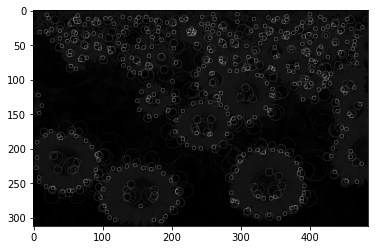

In [35]:
plt.imshow(blob_img, cmap="gray")

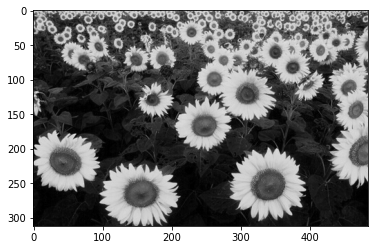

In [30]:
plt.imshow(new_img, cmap="gray")